# Preprocessing

- The LPIS field parcel data (geometries and class labels) are cleaned and preprocssed by a geopandas pipeline.
- The RGB-Sentinel-2 imagery is cut to 128x128-pixel image chips. 
- The preprocessed LPIS data is clipped to matching chip geometries and saved in COCO annotation format.

This repository only contains data for a small subset of the full Denmark region of interest for demonstration purposes. Imagery and geometry data for the full roi would take up several gigabytes. The full 2016 LPIS "marker" dataset set can be downloaded here:
https://kortdata.fvm.dk/download/Markblokke_Marker?page=MarkerHistoriske

![Subset chip cutting example](msc_codeshare/test_aoi_subset.png)

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import shapely
from PIL import Image as pilimage
import pprint

import utils
from utils.other import new_pickle, load_pickle, new_json, load_json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Vector preparation 

In [11]:
input_s2 = Path(r'data\RGB_small.tif')
input_fields = Path(r'data\marker2016_small.shp')

output = Path(r'output\preprocessed')
output_fields = output / 'prepared_vector.shp'

In [19]:
def prepare_vector(fp, out_crs, clipping_bounds):
    df = (gpd.read_file(str(fp), encoding='cp865')  # danish encoding
             .rename(columns={'Afgroede': 'lc_name', 'AfgKode': 'lc_id', 'JOURNALNUM': 'journalnr'})
             .drop(['GB', 'GEOMETRISK', 'MARKNUMMER'], axis=1)
             .pipe(utils.geo.explode_mp)
             .pipe(utils.geo.buffer_zero)
             .pipe(utils.geo.close_holes)
             .pipe(utils.geo.set_crs, 3044)
             .to_crs(out_crs)
             .pipe(utils.geo.clip, clip_poly=shapely.geometry.box(*clipping_bounds), explode_mp_=True)
             .pipe(utils.geo.reclassify_col, rcl_scheme=utils.geo.reclass_legend, 
                   col_classlabels='lc_name', col_classids='lc_id', drop_other_classes=True)
             .assign(geometry=lambda _df: _df.geometry.simplify(5, preserve_topology=True))
             .pipe(utils.geo.buffer_zero)
             .assign(area_sqm=lambda _df: _df.geometry.area)
             .pipe(utils.geo.reduce_precision, precision=4)
             .reset_index(drop=True)
             .assign(fid=lambda _df: range(0, len(_df.index)))
             .filter(['journalnr', 'lc_id', 'lc_name', 'r_lc_id', 'r_lc_name', 
                      'area_sqm', 'fid', 'geometry']))
    return df


if not output_fields.exists():
    with rasterio.open(input_s2) as src:
        raster_meta = src.meta
        raster_bounds = src.bounds
    df = prepare_vector(input_fields, raster_meta['crs'], raster_bounds)
    output_fields.parent.mkdir(parents=True, exist_ok=True)
    df.to_file(output_fields, driver='ESRI Shapefile', encoding='cp865')
else:
    print(f'Loading from exisiting output... {output_fields.name}')
    df = gpd.read_file(str(output_fields), encoding='cp865')
     
print('df.info()', df.info())
display(df.head(3))

Loading from exisiting output... prepared_vector.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 8 columns):
journalnr    234 non-null object
lc_id        234 non-null object
lc_name      234 non-null object
r_lc_id      234 non-null int64
r_lc_name    234 non-null object
area_sqm     234 non-null float64
fid          234 non-null int64
geometry     234 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 14.7+ KB
df.info() None


,journalnr,lc_id,lc_name,r_lc_id,r_lc_name,area_sqm,fid,geometry
0,16-0020644,1,Vσrbyg,1,springcereal,6818.565562,0,"POLYGON ((516576.3102 6243070.0001, 516595.983..."
1,16-0036135,11,Vinterhvede,2,wintercereal,15477.545517,1,"POLYGON ((514093.8795 6243688.6454, 514192.095..."
2,16-0014547,280,Fodersukkerroer,5,other,54178.844742,2,"POLYGON ((515329.0988 6243575.5184, 515447.500..."


### Crop vector to chip geometries & export as COCO annotations

In [20]:
# Cut vevotrs to chip geometries. 

output_chips = output / 'chip_dfs.pkl'
chip_width, chip_height = 128, 128

if not output_chips.exists():
    with rasterio.open(input_s2) as src:
        raster_meta = src.meta
        raster_bounds = src.bounds 
    chip_dfs = utils.geo.cut_chip_geometries(vector_df=df,
                                                 raster_width=raster_meta['width'],
                                                 raster_height=raster_meta['height'],
                                                 raster_transform=raster_meta['transform'],
                                                 chip_width=chip_width,
                                                 chip_height=chip_height)
    new_pickle(out_fp=output_chips, data=chip_dfs)
else:
    all_chip_dfs = load_pickle(in_fp=output_chips)
    
print('len', len(chip_dfs))

Loading from pickle file... chip_dfs.pkl
len 9


In [21]:
# Convert to COCO annotation format (contains test/test split) and export.

train_chip_dfs, val_chip_dfs = utils.coco.train_test_split(chip_dfs, test_size=0.2, seed=1)
coco_train = utils.coco.format_coco(train_chip_dfs, chip_width, chip_height)
coco_val = utils.coco.format_coco(val_chip_dfs, chip_width, chip_height)
new_json(output / r'annotations\train2016.json', coco_train)
new_json(output / r'annotations\val2016.json', coco_val)

Writing new json file... train2016.json
Writing new json file... val2016.json


### Crop images to chips

In [22]:
# Cut to chip images and write to disk, retrieve chip image statistics
    
chip_windows = {chip_name : value['chip_window'] for chip_name, value in chip_dfs.items()}
chip_statistics = utils.img.cut_chip_images(input_s2,
                                       chip_names=chip_windows.keys(),
                                       chip_windows=chip_windows.values(), 
                                       out_folder=output / r'image_chips\train2016', 
                                       bands=[3, 2, 1])

utils.coco.move_coco_val_images(val_chips_list = val_chip_dfs.keys(), 
                                path_train_folder=output / r'image_chips\train2016')

print('len', len(chip_statistics))

9it [00:00, 31.69it/s]


len 9


### Save statistics

In [25]:
statistics = {
    'nr_chips': len(chip_dfs.keys()),
    'nr_chips_train': len(train_chip_dfs),
    'nr_chips_val': len(val_chip_dfs),
    'nr_polys': sum([len(df['chip_df']) for df in chip_dfs.values()]),
    'nr_polys_train': sum([len(df['chip_df']) for df in train_chip_dfs.values()]),
    'nr_polys_val': sum([len(df['chip_df']) for df in val_chip_dfs.values()]),
    'avg_polys_per_chip': sum([len(df['chip_df']) for df in chip_dfs.values()]) / len(chip_dfs.keys()),
    'train_rgb_mean': list(np.asarray([df['mean'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
    'train_rgb_std': list(np.asarray([df['std'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0))
    }

new_json(output / 'statistics.json', statistics)
pprint.pprint(statistics)

Writing new json file... statistics.json
{'avg_polys_per_chip': 28.0,
 'nr_chips': 9,
 'nr_chips_train': 7,
 'nr_chips_val': 2,
 'nr_polys': 252,
 'nr_polys_train': 192,
 'nr_polys_val': 60,
 'train_rgb_mean': [94.87407575334821, 106.43259974888393, 117.06084333147321],
 'train_rgb_std': [29.676533028155795, 14.783947366623368, 14.194860301379379]}


### Visualize preprocessed chip images and COCO annotations

Loading from json file... val2016.json
COCO_val2016_000000100005.jpg


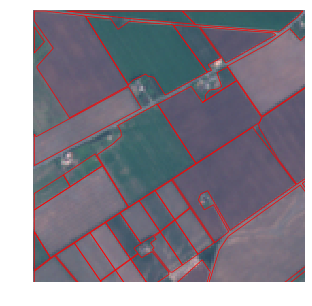

COCO_val2016_000000100006.jpg


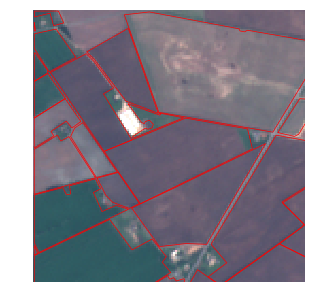

In [24]:
utils.coco.plot_coco(in_json=output / r'annotations\val2016.json', 
                     chip_img_folder=output / r'image_chips\val2016', 
                     end=2)